In [2]:
pip install bs4

  Preparing metadata (setup.py) ... done
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1256 sha256=2476a7e30c2c21de2227cf3b45c244605d506f5df497fac0d9e597d5c86306b4
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
Successfully built bs4


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import pandas as pd
import re
import glob
import os
import numpy as np

def smi_to_df(file_path):
    file = open(file_path, 'r', encoding='cp949')
    wholefile = file.readlines()
    pattern = re.compile(r'<SYNC Start=(\d+)><P Class=KRCC>\n(.*?)\n', re.DOTALL)
    matches = pattern.findall(''.join(wholefile))
    df = pd.DataFrame(matches, columns=['Time_Stamp(s)', 'Text'])
    df['Time_Stamp(s)'] = df['Time_Stamp(s)'].astype(float) / 1000

    # 파일 경로에서 teacher, class_name, lecture_name 추출
    file_parts = file_path.split('/')
    teacher_name = file_parts[-3]
    class_name = file_parts[-2]

    # class_name 경로 내의 있는 파일명에서 . 이전까지의 이름을 lecture_name으로 추출
    lecture_name = file_parts[-1].split('.')[0]

    # 데이터프레임에 컬럼 추가
    df['teacher'] = teacher_name
    df['class_name'] = class_name
    df['lecture_name'] = lecture_name

    return df

def convert_to_percentage(df):
    start_timestamp = df['Time_Stamp(s)'].min()
    end_timestamp = df['Time_Stamp(s)'].max()
    df['Scaled_Percent'] = (df['Time_Stamp(s)'] - start_timestamp) / (end_timestamp - start_timestamp) * 100
    return df

def calculate_speed(df):
    df['Time_difference'] = df['Time_Stamp(s)'].shift(-1) - df['Time_Stamp(s)']
    df['Time_difference'].fillna(0, inplace=True)
    df['words'] = df['Text'].apply(lambda x: len(x))
    df = df[(df['Time_difference'] < 20) & (df['Time_difference'] > 1) & (df['words'] > 10)]
    df['speed'] = df['Time_difference'] / df['words']
    return df

def calculate_interval_speed(df, interval):
    unique_lecture_names = df['lecture_name'].unique()
    interval_speeds_df = pd.DataFrame(index=range(1, 101), columns=unique_lecture_names)

    for lecture_name in unique_lecture_names:
        lecture_df = df[df['lecture_name'] == lecture_name]
        interval_speeds = []

        for i in range(0, 100, interval):
            subset_df = lecture_df[(lecture_df['Scaled_Percent'] >= i) & (lecture_df['Scaled_Percent'] < i + interval)]
            median_speed = np.nanmedian(subset_df['speed']) if not subset_df.empty else np.nan
            interval_speeds.append(median_speed)

        interval_speeds_df[lecture_name] = interval_speeds

    return interval_speeds_df

def main():
    smi_file_path = "/content/drive/MyDrive/인강프로젝트/EBS 스크립트 데이터/인기 강사/정유빈/[2024 수능특강] 정유빈의 확률과 통계"
    smi_file_names = [os.path.join(smi_file_path, file) for file in os.listdir(smi_file_path) if file.endswith(".smi") and os.path.isfile(os.path.join(smi_file_path, file))]

    interval = 1  # 1% 간격으로 계산

    combined_df = pd.DataFrame()  # 빈 데이터프레임 생성
    for file_path in smi_file_names:
        df = smi_to_df(file_path)
        df = convert_to_percentage(df)
        df = calculate_speed(df)

        # Calculate median speed for each 1% interval
        median_speeds = []
        for i in range(0, 100, interval):
            subset_df = df[(df['Scaled_Percent'] >= i) & (df['Scaled_Percent'] < i + interval)]
            median_speed = np.nanmedian(subset_df['speed']) if not subset_df.empty else np.nan
            median_speeds.extend([median_speed] * len(subset_df))  # Extend the list to match the length of subset_df

        df['speed_median'] = median_speeds  # Add the 'speed_median' column
        combined_df = pd.concat([combined_df, df])

    # 필요한 컬럼을 선택하여 최종 데이터프레임 생성
    combined_df = combined_df[['Time_Stamp(s)', 'Text', 'Scaled_Percent', 'Time_difference', 'words', 'speed', 'teacher', 'class_name', 'lecture_name', 'speed_median']]

    return combined_df  # 변수 반환


if __name__ == "__main__":
    combined_df_1 = main()  # 함수 실행 결과를 변수에 저장

    # 필요한 컬럼을 선택하여 최종 데이터프레임 출력
    combined_df_1 = combined_df_1[['Time_Stamp(s)', 'Text', 'Scaled_Percent', 'Time_difference', 'words', 'speed', 'teacher', 'class_name', 'lecture_name', 'speed_median']]


<ipython-input-16-8f38d35b2fe7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['speed'] = df['Time_difference'] / df['words']
<ipython-input-16-8f38d35b2fe7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['speed'] = df['Time_difference'] / df['words']
<ipython-input-16-8f38d35b2fe7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [17]:
combined_df_1.to_csv('/content/drive/MyDrive/인강프로젝트/분석결과/말속도/정유빈_[2024 수능특강] 정유빈의 확률과 통계.csv', index=False)

In [5]:
combined_df_1.head()

,Time_Stamp(s),Text,Scaled_Percent,Time_difference,words,speed,teacher,class_name,lecture_name,speed_median
0,13.394,"여러분, 반갑습니다. 확률, 통계에 반짝이는 느낌표를 찍어줄 서지나입니다. 우리 오...",0.000000,12.444,80,0.155550,서지나,[올림포스] 확률과 통계,1강,0.139245
1,25.838,선생님도 그랬어요. 오늘 첫 강의 찍는다고 하니까 어저께 밤에 잠이 안 오더라고요....,0.429146,13.646,98,0.139245,서지나,[올림포스] 확률과 통계,1강,0.139245
2,39.484,일단은 우리가 이 교재를 다 끝내고 났을 때 분명히 여러분들은 성장해 있을 거예요....,0.899745,10.767,81,0.132926,서지나,[올림포스] 확률과 통계,1강,0.139245
3,50.251,그게 설렘 아닐까 싶고요. 두려운 것들은 조금 이제 접어두고요. 선생님은 이 새 교...,1.271058,12.237,96,0.127469,서지나,[올림포스] 확률과 통계,1강,0.126611
4,62.488,완벽히 분석하고 또 이 문제집을 어떻게 하면 여러분들의 것으로 만들 수 있을지에 대...,1.693065,9.180,73,0.125753,서지나,[올림포스] 확률과 통계,1강,0.126611


In [ ]:
pip install koreanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 16.2 MB/s eta 0:00:00


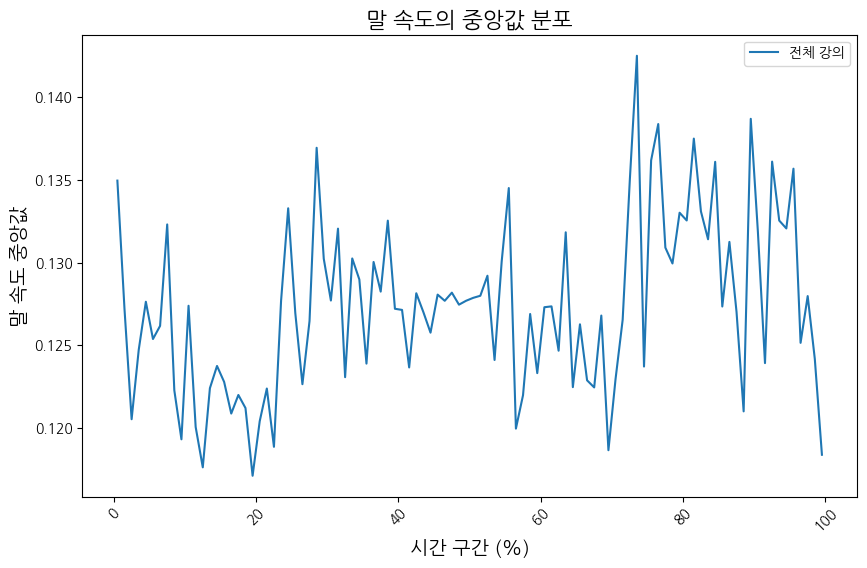

In [ ]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 중복값 제거 및 정렬
unique_data = combined_df_2[['Scaled_Percent', 'speed_median']].drop_duplicates().sort_values(by='Scaled_Percent')

# 1% 간격으로 잘라서 구간별 중앙값 계산
interval = 1
max_percent = unique_data['Scaled_Percent'].max()
bins = np.arange(0, max_percent + interval, interval)
unique_data['Scaled_Percent_Bin'] = pd.cut(unique_data['Scaled_Percent'], bins=bins, include_lowest=True)
grouped_data = unique_data.groupby('Scaled_Percent_Bin').median()

# 범주형 데이터를 수치형으로 변환
grouped_data['Scaled_Percent'] = grouped_data.index.categories.mid

# 그래프 설정
plt.figure(figsize=(10, 6))
plt.plot(grouped_data['Scaled_Percent'], grouped_data['speed_median'], linestyle='-', label='전체 강의')

# 그래프 세부 설정
plt.title('말 속도의 중앙값 분포', fontsize=16)
plt.xlabel('시간 구간 (%)', fontsize=14)
plt.ylabel('말 속도 중앙값', fontsize=14)
plt.xticks(rotation=45)
plt.legend()

# 그래프 표시
plt.show()


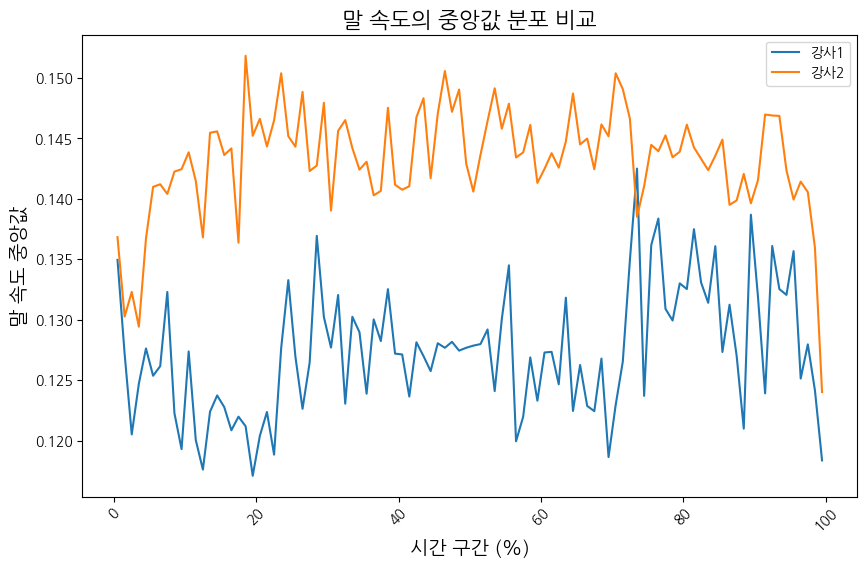

In [ ]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 중복값 제거 및 정렬 (강사1)
unique_data_2 = combined_df_2[['Scaled_Percent', 'speed_median']].drop_duplicates().sort_values(by='Scaled_Percent')

# 중복값 제거 및 정렬 (강사2)
unique_data_3 = combined_df_3[['Scaled_Percent', 'speed_median']].drop_duplicates().sort_values(by='Scaled_Percent')

# 1% 간격으로 잘라서 구간별 중앙값 계산 (강사1)
interval = 1
max_percent_2 = unique_data_2['Scaled_Percent'].max()
bins_2 = np.arange(0, max_percent_2 + interval, interval)
unique_data_2['Scaled_Percent_Bin'] = pd.cut(unique_data_2['Scaled_Percent'], bins=bins_2, include_lowest=True)
grouped_data_2 = unique_data_2.groupby('Scaled_Percent_Bin').median()

# 1% 간격으로 잘라서 구간별 중앙값 계산 (강사2)
max_percent_3 = unique_data_3['Scaled_Percent'].max()
bins_3 = np.arange(0, max_percent_3 + interval, interval)
unique_data_3['Scaled_Percent_Bin'] = pd.cut(unique_data_3['Scaled_Percent'], bins=bins_3, include_lowest=True)
grouped_data_3 = unique_data_3.groupby('Scaled_Percent_Bin').median()

# 범주형 데이터를 수치형으로 변환 (강사1)
grouped_data_2['Scaled_Percent'] = grouped_data_2.index.categories.mid

# 범주형 데이터를 수치형으로 변환 (강사2)
grouped_data_3['Scaled_Percent'] = grouped_data_3.index.categories.mid

# 그래프 설정
plt.figure(figsize=(10, 6))

# 강사1 그래프
plt.plot(grouped_data_2['Scaled_Percent'], grouped_data_2['speed_median'], linestyle='-', label='강사1')

# 강사2 그래프
plt.plot(grouped_data_3['Scaled_Percent'], grouped_data_3['speed_median'], linestyle='-', label='강사2')

# 그래프 세부 설정
plt.title('말 속도의 중앙값 분포 비교', fontsize=16)
plt.xlabel('시간 구간 (%)', fontsize=14)
plt.ylabel('말 속도 중앙값', fontsize=14)
plt.xticks(rotation=45)
plt.legend()

# 그래프 표시
plt.show()
